In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score

from nltk.corpus import stopwords
import re



from sklearn.ensemble import GradientBoostingClassifier



import matplotlib.pyplot as plt


In [59]:
df_selftext = pd.read_csv('../../data/cleaned_selftext.csv')
df_notext = pd.read_csv('../../data/cleaned_notext.csv')
df_selftext.head(2)

,subreddit,text
0,0,using electric water boiler to mine bitcoin th...
1,0,btc to usdt hello i am looking to swap a good ...


In [60]:
print(df_selftext.subreddit.value_counts())
df_notext.subreddit.value_counts()

0    4017
1     787
Name: subreddit, dtype: int64


0    9938
1    2059
Name: subreddit, dtype: int64

# Adding stop words to not make it too easy

In [61]:
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik metamask nft nfts'.split())


# Model

In [62]:
X = df_selftext.text
y = df_selftext.subreddit

In [63]:
y.value_counts()

0    4017
1     787
Name: subreddit, dtype: int64

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [65]:
# Pipeline accepts multiple transformers, but only one vectorizer. See cgpt results:

'''The error message is caused by the fact that you are trying to fit two different vectorizers (TfidfVectorizer and CountVectorizer) 
in the same pipeline, but only providing one input (X_train) to the pipeline. This is causing the pipeline to raise an error as it doesn't 
know which vectorizer to apply to the input. 

You can fix this by either removing one of the vectorizers or providing separate inputs to the pipeline for each vectorizer.'''


gb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier())
])

In [66]:
gb_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'gb__n_estimators': range(50,200,50),
    'gb__max_features': range(50, 80)
}

In [67]:
rs = RandomizedSearchCV(gb_pipe, 
                  gb_pipe_params, 
                    cv = 5) 

In [68]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('gb',
                                              GradientBoostingClassifier())]),
                   param_distributions={'gb__max_features': range(50, 80),
                                        'gb__n_estimators': range(50, 200, 50),
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves

In [69]:
#using all stopwords lowers scores to 0.8823747680890538 / 0.8654060066740823

print(rs.score(X_train, y_train))
rs.score(X_test, y_test)

0.9206217041354426


0.8767693588676103

In [70]:
rs.best_params_

{'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again'

In [71]:
rs.score(X_test, y_test)

0.8767693588676103

In [72]:
preds = rs.predict(X_test)

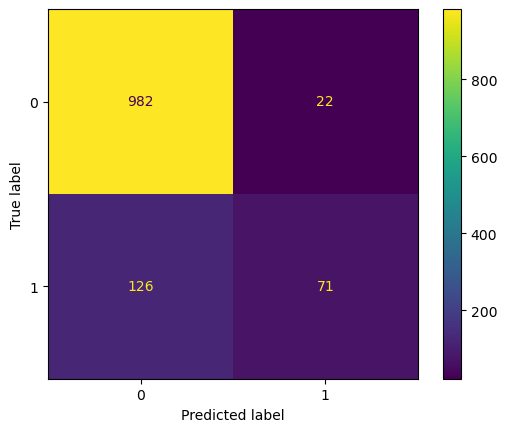

In [73]:
cm = confusion_matrix(y_test, preds)

display = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = rs.classes_)

display.plot();

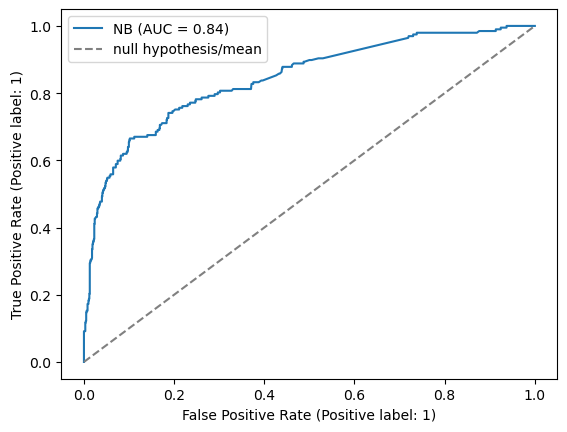

In [74]:
# Basic ROC

# cf ROC
# create an ax object
ax = plt.gca()

# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rs, X_test, y_test, ax=ax, name='NB')

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

# necessary to label the baseline
plt.legend();

# Preds analysis

In [75]:
pred_df = pd.DataFrame(rs.predict_proba(X_test),columns=['bitcoin', 'ethereum'])

pred_df['true_values'] = y_test.values

pred_df.head()


,bitcoin,ethereum,true_values
0,0.922865,0.077135,0
1,0.339712,0.660288,1
2,0.905713,0.094287,0
3,0.832721,0.167279,0
4,0.935342,0.064658,0


In [76]:
full_pred_df = pd.DataFrame(rs.predict_proba(X),columns=['bitcoin', 'ethereum'])

In [77]:
full_pred_df['true_values'] = y.values

full_pred_df.head()

,bitcoin,ethereum,true_values
0,0.928904,0.071096,0
1,0.937977,0.062023,0
2,0.850264,0.149736,0
3,0.919445,0.080555,0
4,0.682735,0.317265,0


In [78]:
df_selftext = df_selftext.join(full_pred_df)

In [79]:
df_selftext.sort_values(by = 'bitcoin')[0:100]

,subreddit,text,bitcoin,ethereum,true_values
4043,1,idea fully decentralized pixel war with decent...,0.007529,0.992471,1
4621,1,fifacup win we are li on pinksale presale time...,0.009000,0.991000,1
4197,1,do similar address on ethereum and polygon cha...,0.010398,0.989602,1
4022,1,on chain privacy for enterprise a nightfall up...,0.013156,0.986844,1
4237,1,deep a decentralized gaming platform built on ...,0.014064,0.985936,1
...,...,...,...,...,...
4407,1,here s how l are planning on moving from fast ...,0.127351,0.872649,1
4534,1,layer solution zk rollups according to vitalik...,0.127713,0.872287,1
4765,1,could someone eli why i see people saying poly...,0.128161,0.871839,1
4183,1,smartlink marketplace buy and sell anything us...,0.132039,0.867961,1


# Which bitcoin users are most susceptible to eth (or are we just modeling words)

In [80]:
df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)].sort_values(by = 'bitcoin', ascending = False)

,subreddit,text,bitcoin,ethereum,true_values
4622,1,anyone else ner heard of ftx or sbf just got t...,0.939248,0.060752,1
4574,1,staked eth what are your thought on having eth...,0.937616,0.062384,1
4420,1,psa selling your worthless nfts can help you s...,0.937001,0.062999,1
4663,1,eth or btc since eth is at k rn and btc at k i...,0.935342,0.064658,1
4229,1,ethereum deflationary is ethereum truly deflat...,0.934727,0.065273,1
...,...,...,...,...,...
4165,1,what is eth btc rsi crossor i ha a wallet wher...,0.506694,0.493306,1
4670,1,eth app idea i'm planning to possibly build a ...,0.505764,0.494236,1
4161,1,ethereum v bitcoin hi i m an actuarial analyst...,0.505450,0.494550,1
4454,1,anti phishing in a web era hi people of etheri...,0.503215,0.496785,1


# False negatives

In [81]:
# uncomment to see "ethish BTC"

#for i in df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)]['text']:
#    print(i, '\n')

# False Positives

In [82]:
FP = pred_df.loc[(pred_df['ethereum'] > .5) & (pred_df.true_values == 0)].index.values.astype(int)

In [83]:
for i in df_selftext.iloc[FP].text:
    print(i,'\n')

bitcoin revolution the future of finance is here bitcoin ha come a long way since it inception or a decade ago from a small group of enthusiast to a global moment of beliers in decentralization and financial freedom a we look to the future it's important to remember that bitcoin is still in it early stage the technology is constantly evolving and more and more people are starting to realize the potential of this revolutionary digital asset it's easy to get caught up in the day to day fluctuation of the price but it's important to remember the bigger picture bitcoin is about so much more than just the price it's about creating a decentralized financial system that put power back in the hand of the people it's about giving individual the ability to take control of their own financial destiny bitcoin is still in it infancy and there are still many challenge to orcome but with ery obstacle we are one step closer to realizing the true potential of this revolutionary technology so let's stay

In [84]:
#notes
def class_from_prob(probabilities, threshold):

    return [0 if prob < threshold else 1 for prob in probabilities]


In [85]:
threshold_list = [round(i*.01,2) for i in range(0,101,)]
speclist = []
senslist = []
f1list = []

for threshold in threshold_list:
    predicted_classes = class_from_prob(pred_df['ethereum'], threshold)
    spec = specificity_score(y_test, predicted_classes)
    sens = recall_score(y_test, predicted_classes, pos_label=1)
    speclist.append(spec)
    senslist.append(sens)
    F1 = f1_score(y_test, predicted_classes)
    f1list.append(F1)

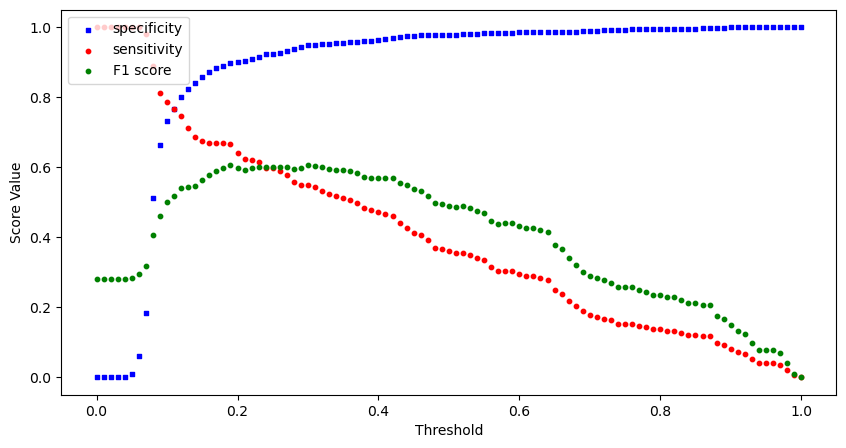

<Figure size 640x480 with 0 Axes>

In [86]:
%matplotlib inline
fig = plt.figure(figsize = (10,5));
ax1 = fig.add_subplot(111);

ax1.scatter(x = threshold_list, y = speclist, s=10, c='b', marker="s", label='specificity');
ax1.scatter(x = threshold_list,y = senslist, s=10, c='r', marker="o", label='sensitivity');
ax1.scatter(x = threshold_list,y = f1list, s=10, c='g', marker="o", label='F1 score');
plt.legend(loc='upper left')
plt.xlabel('Threshold');
plt.ylabel('Score Value');
plt.show();
plt.tight_layout();
